# **Sydney House Price Prediction using Machine Learning**

In [1]:
import os
os.chdir('/home/atharvakatkar/personal_projects/Sydney-House-Price-Predictor')
print("Working directory:", os.getcwd())

Working directory: /home/atharvakatkar/personal_projects/Sydney-House-Price-Predictor


In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time
from datetime import datetime

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

# Model persistence and explainability
import joblib
import shap

# Utilities
import warnings
warnings.filterwarnings("ignore")

/home/atharvakatkar/personal_projects/Sydney-House-Price-Predictor/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Import

In [3]:
# LOAD DATASETS
domain = pd.read_csv("data/raw/domain_properties.csv")
suburb = pd.read_csv("data/raw/syd_sub_rev.csv")

In [4]:
# CHECKING DATA
print("Domain Properties\n")
print(domain.info())
print(domain.head())
print(domain.describe())

print("\n\nSydney Suburb Review\n")
print(suburb.info())
print(suburb.head())
print(suburb.describe())

Domain Properties

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     11160 non-null  int64  
 1   date_sold                 11160 non-null  object 
 2   suburb                    11160 non-null  object 
 3   num_bath                  11160 non-null  int64  
 4   num_bed                   11160 non-null  int64  
 5   num_parking               11160 non-null  int64  
 6   property_size             11160 non-null  int64  
 7   type                      11160 non-null  object 
 8   suburb_population         11160 non-null  int64  
 9   suburb_median_income      11160 non-null  int64  
 10  suburb_sqkm               11160 non-null  float64
 11  suburb_lat                11160 non-null  float64
 12  suburb_lng                11160 non-null  float64
 13  suburb_elevation          11160 non-null  

### Basic Data Cleaning

In [5]:
# COLUMN STANDARDISATION
domain.columns = domain.columns.str.strip().str.lower().str.replace(" ", "_")
suburb.columns = suburb.columns.str.strip().str.lower().str.replace(" ", "_")

In [6]:
# CLEAN COLUMN NAMES FOR DISPLAY
def clean_col_name(col):
    return col.replace("_", " ").replace("%", "percentage").title()

domain.columns = [clean_col_name(col) for col in domain.columns]
suburb.columns = [clean_col_name(col) for col in suburb.columns]

print("Domain columns:", domain.columns.tolist())
print("Suburb columns:", suburb.columns.tolist())

Domain columns: ['Price', 'Date Sold', 'Suburb', 'Num Bath', 'Num Bed', 'Num Parking', 'Property Size', 'Type', 'Suburb Population', 'Suburb Median Income', 'Suburb Sqkm', 'Suburb Lat', 'Suburb Lng', 'Suburb Elevation', 'Cash Rate', 'Property Inflation Index', 'Km From Cbd']
Suburb columns: ['Name', 'Region', 'Population (Rounded)*', 'Postcode', 'Ethnic Breakdown 2016', 'Median House Price (2020)', 'Median House Price (2021)', 'Percentage Change', 'Median House Rent (Per Week)', 'Median Apartment Price (2020)', 'Median Apartment Rent (Per Week)', 'Public Housing Percentage', 'Avg. Years Held', 'Time To Cbd (Public Transport) [Town Hall St]', 'Time To Cbd (Driving) [Town Hall St]', 'Nearest Train Station', 'Highlights/Attractions', 'Ideal For', 'Traffic', 'Public Transport', 'Affordability (Rental)', 'Affordability (Buying)', 'Nature', 'Noise', 'Things To See/Do', 'Family-Friendliness', 'Pet Friendliness', 'Safety', 'Overall Rating', 'Review Link']


In [7]:
# SUBURB CLEANING
suburb.rename(columns={"Name": "Suburb"}, inplace=True)

print(suburb["Suburb"].nunique(), "unique suburbs out of", suburb.shape[0], "rows")
print(suburb["Suburb"].duplicated().sum(), "duplicate suburb entries")

print(suburb.columns.to_list())

421 unique suburbs out of 421 rows
0 duplicate suburb entries
['Suburb', 'Region', 'Population (Rounded)*', 'Postcode', 'Ethnic Breakdown 2016', 'Median House Price (2020)', 'Median House Price (2021)', 'Percentage Change', 'Median House Rent (Per Week)', 'Median Apartment Price (2020)', 'Median Apartment Rent (Per Week)', 'Public Housing Percentage', 'Avg. Years Held', 'Time To Cbd (Public Transport) [Town Hall St]', 'Time To Cbd (Driving) [Town Hall St]', 'Nearest Train Station', 'Highlights/Attractions', 'Ideal For', 'Traffic', 'Public Transport', 'Affordability (Rental)', 'Affordability (Buying)', 'Nature', 'Noise', 'Things To See/Do', 'Family-Friendliness', 'Pet Friendliness', 'Safety', 'Overall Rating', 'Review Link']


In [8]:
# TYPE CONVERSION FUNCTIONS
def clean_currency(val):
    if isinstance(val, str):
        return pd.to_numeric(val.replace("$", "").replace(",", ""), errors="coerce")
    return val

def clean_percent(val):
    if isinstance(val, str):
        return pd.to_numeric(val.replace("%", ""), errors="coerce")
    return val

def clean_int(val):
    if isinstance(val, str):
        return pd.to_numeric(val.replace(",", ""), errors="coerce")
    return val

# APPLY TYPE CONVERSIONS
currency_cols = [
    "Median House Price (2020)", "Median House Price (2021)",
    "Median Apartment Price (2020)", "Median House Rent (Per Week)",
    "Median Apartment Rent (Per Week)"
]
percent_cols = ["Percentage Change", "Public Housing Percentage"]
int_cols = ["Population (Rounded)*"]

for col in currency_cols:
    suburb[col] = suburb[col].apply(clean_currency)
for col in percent_cols:
    suburb[col] = suburb[col].apply(clean_percent)
for col in int_cols:
    suburb[col] = suburb[col].apply(clean_int)

print("Type conversion complete")
suburb.dtypes

Type conversion complete


Suburb                                            object
Region                                            object
Population (Rounded)*                              int64
Postcode                                           int64
Ethnic Breakdown 2016                             object
Median House Price (2020)                        float64
Median House Price (2021)                        float64
Percentage Change                                float64
Median House Rent (Per Week)                     float64
Median Apartment Price (2020)                    float64
Median Apartment Rent (Per Week)                 float64
Public Housing Percentage                        float64
Avg. Years Held                                  float64
Time To Cbd (Public Transport) [Town Hall St]     object
Time To Cbd (Driving) [Town Hall St]              object
Nearest Train Station                             object
Highlights/Attractions                            object
Ideal For                      

In [9]:
# DROPPING IRRELEVANT COLUMNS
suburb.drop(columns=[
    "Region",
    "Ethnic Breakdown 2016",
    "Nearest Train Station",
    "Highlights/Attractions",
    "Ideal For",
    "Review Link",
    "Things To See/Do",
    "Postcode"
], inplace=True, errors="ignore")

print("Columns after dropping:", suburb.shape[1])

Columns after dropping: 22


In [10]:
# EXTRACT NUMERICAL TRAVEL TIMES
for col in ["Time To Cbd (Public Transport) [Town Hall St]", "Time To Cbd (Driving) [Town Hall St]"]:
    suburb[col] = suburb[col].str.extract(r"(\d+)").astype(float)

print("Travel time conversion complete")

Travel time conversion complete


In [11]:
# NULL CHECK
print(suburb.isnull().sum().sort_values(ascending=False))
print("\nData types:")
print(suburb.dtypes)

Median Apartment Price (2020)                    122
Median Apartment Rent (Per Week)                  71
Avg. Years Held                                   51
Median House Rent (Per Week)                      19
Median House Price (2021)                         15
Percentage Change                                  4
Time To Cbd (Public Transport) [Town Hall St]      4
Median House Price (2020)                          3
Public Housing Percentage                          2
Time To Cbd (Driving) [Town Hall St]               2
Traffic                                            2
Affordability (Buying)                             1
Affordability (Rental)                             1
Public Transport                                   1
Family-Friendliness                                1
Pet Friendliness                                   1
Nature                                             1
Noise                                              1
Safety                                        

In [12]:
# FILL NULL NUMERIC VALUES WITH MEDIAN
median_cols = [
    'Median Apartment Price (2020)',
    'Median Apartment Rent (Per Week)',
    'Avg. Years Held',
    'Median House Rent (Per Week)',
    'Median House Price (2021)',
    'Median House Price (2020)',
    'Percentage Change',
    'Traffic',
    'Public Housing Percentage',
    'Time To Cbd (Public Transport) [Town Hall St]',
    'Time To Cbd (Driving) [Town Hall St]'
]

suburb[median_cols] = suburb[median_cols].fillna(suburb[median_cols].median())
print("Nulls remaining:", suburb[median_cols].isnull().sum().sum())
suburb.sample(5)

Nulls remaining: 0


,Suburb,Population (Rounded)*,Median House Price (2020),Median House Price (2021),Percentage Change,Median House Rent (Per Week),Median Apartment Price (2020),Median Apartment Rent (Per Week),Public Housing Percentage,Avg. Years Held,...,Traffic,Public Transport,Affordability (Rental),Affordability (Buying),Nature,Noise,Family-Friendliness,Pet Friendliness,Safety,Overall Rating
23,Carlton,11000,1250000.0,1400000.0,12.00,590.0,655000.0,465.0,2.0,14.7,...,5.0,6.0,6.0,5.0,6.0,8.0,8.0,8.0,8.0,6.4
394,Wareemba,1600,1850000.0,2100000.0,13.51,750.0,725000.0,600.0,1.0,10.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,Harrington Park,10750,920000.0,1100000.0,19.57,550.0,725000.0,500.0,0.0,7.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376,Cabarita,2000,2500000.0,2650000.0,6.00,920.0,1700000.0,890.0,1.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355,Castle Cove,2750,2500000.0,3300000.0,32.00,1100.0,725000.0,500.0,0.0,17.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# CHECK ZERO COUNTS IN RATING COLUMNS
cols = [
    "Traffic", "Public Transport", "Affordability (Rental)", "Affordability (Buying)",
    "Nature", "Noise", "Family-Friendliness", "Pet Friendliness",
    "Safety", "Overall Rating"
]

zero_counts = {col: (suburb[col] == 0).sum() for col in cols}
print(zero_counts)

{'Traffic': np.int64(303), 'Public Transport': np.int64(302), 'Affordability (Rental)': np.int64(302), 'Affordability (Buying)': np.int64(302), 'Nature': np.int64(302), 'Noise': np.int64(302), 'Family-Friendliness': np.int64(302), 'Pet Friendliness': np.int64(302), 'Safety': np.int64(302), 'Overall Rating': np.int64(302)}


In [14]:
# DROP SUBJECTIVE RATING COLUMNS
suburb.drop(columns=cols, inplace=True, errors="ignore")
print("Remaining columns:", suburb.columns.tolist())

Remaining columns: ['Suburb', 'Population (Rounded)*', 'Median House Price (2020)', 'Median House Price (2021)', 'Percentage Change', 'Median House Rent (Per Week)', 'Median Apartment Price (2020)', 'Median Apartment Rent (Per Week)', 'Public Housing Percentage', 'Avg. Years Held', 'Time To Cbd (Public Transport) [Town Hall St]', 'Time To Cbd (Driving) [Town Hall St]']


In [15]:
# FINAL NULL VERIFICATION
print("Remaining nulls:")
print(suburb.isnull().sum())
print("\nSuburb dataset shape:", suburb.shape)
suburb.head(5)

Remaining nulls:
Suburb                                           0
Population (Rounded)*                            0
Median House Price (2020)                        0
Median House Price (2021)                        0
Percentage Change                                0
Median House Rent (Per Week)                     0
Median Apartment Price (2020)                    0
Median Apartment Rent (Per Week)                 0
Public Housing Percentage                        0
Avg. Years Held                                  0
Time To Cbd (Public Transport) [Town Hall St]    0
Time To Cbd (Driving) [Town Hall St]             0
dtype: int64

Suburb dataset shape: (421, 12)


,Suburb,Population (Rounded)*,Median House Price (2020),Median House Price (2021),Percentage Change,Median House Rent (Per Week),Median Apartment Price (2020),Median Apartment Rent (Per Week),Public Housing Percentage,Avg. Years Held,Time To Cbd (Public Transport) [Town Hall St],Time To Cbd (Driving) [Town Hall St]
0,Hornsby,23000,1150000.0,1400000.0,21.74,600.0,645000.0,460.0,3.0,12.9,40.0,35.0
1,Oatley,10500,1550000.0,1800000.0,16.13,670.0,780000.0,470.0,0.0,13.7,30.0,30.0
2,Dulwich Hill,14500,1500000.0,1900000.0,26.67,725.0,780000.0,475.0,2.0,14.0,20.0,20.0
3,Jannali,6250,1050000.0,1300000.0,23.81,610.0,620000.0,465.0,8.0,13.7,35.0,45.0
4,Waverton,3250,2650000.0,3400000.0,28.30,1000.0,1200000.0,630.0,1.0,12.0,10.0,15.0


In [16]:
# DOMAIN DATASET OVERVIEW
print(domain.info())
print("\n")
print(domain.describe(include='all'))
domain.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     11160 non-null  int64  
 1   Date Sold                 11160 non-null  object 
 2   Suburb                    11160 non-null  object 
 3   Num Bath                  11160 non-null  int64  
 4   Num Bed                   11160 non-null  int64  
 5   Num Parking               11160 non-null  int64  
 6   Property Size             11160 non-null  int64  
 7   Type                      11160 non-null  object 
 8   Suburb Population         11160 non-null  int64  
 9   Suburb Median Income      11160 non-null  int64  
 10  Suburb Sqkm               11160 non-null  float64
 11  Suburb Lat                11160 non-null  float64
 12  Suburb Lng                11160 non-null  float64
 13  Suburb Elevation          11160 non-null  int64  
 14  Cash R

,Price,Date Sold,Suburb,Num Bath,Num Bed,Num Parking,Property Size,Type,Suburb Population,Suburb Median Income,Suburb Sqkm,Suburb Lat,Suburb Lng,Suburb Elevation,Cash Rate,Property Inflation Index,Km From Cbd
0,530000,13/1/16,Kincumber,4,4,2,1351,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05
1,525000,13/1/16,Halekulani,2,4,2,594,House,2538,24752,1.397,-33.21772,151.55237,23,2.0,150.9,78.54
2,480000,13/1/16,Chittaway Bay,2,4,2,468,House,2028,31668,1.116,-33.32678,151.44557,3,2.0,150.9,63.59
3,452000,13/1/16,Leumeah,1,3,1,344,House,9835,32292,4.055,-34.05375,150.83957,81,2.0,150.9,40.12
4,365500,13/1/16,North Avoca,0,0,0,1850,Vacant land,2200,45084,1.497,-33.45608,151.43598,18,2.0,150.9,49.98


In [17]:
# CONVERT DATE SOLD TO DATETIME
domain["Date Sold"] = pd.to_datetime(domain["Date Sold"], format="%d/%m/%y", errors="coerce")

invalid_dates = domain[domain["Date Sold"].isna()]
print("Invalid dates found:", len(invalid_dates))
invalid_dates.head()

Invalid dates found: 0


,Price,Date Sold,Suburb,Num Bath,Num Bed,Num Parking,Property Size,Type,Suburb Population,Suburb Median Income,Suburb Sqkm,Suburb Lat,Suburb Lng,Suburb Elevation,Cash Rate,Property Inflation Index,Km From Cbd


In [18]:
# PROPERTY FEATURE DISTRIBUTIONS
domain[["Num Bath", "Num Bed", "Num Parking", "Property Size"]].describe()

,Num Bath,Num Bed,Num Parking,Property Size
count,11160.000000,11160.000000,11160.000000,11160.000000
mean,2.073566,3.758961,2.017473,723.012366
std,1.184881,1.559743,1.454560,1048.983662
min,0.000000,0.000000,0.000000,7.000000
25%,1.000000,3.000000,1.000000,430.000000
50%,2.000000,4.000000,2.000000,600.000000
75%,3.000000,4.000000,2.000000,765.000000
max,46.000000,47.000000,50.000000,59100.000000


In [19]:
# OUTLIER COUNTS
print("Bath outliers (>10):", domain[domain['Num Bath'] > 10].shape[0])
print("Bed outliers (>10):", domain[domain['Num Bed'] > 10].shape[0])
print("Parking outliers (>10):", domain[domain['Num Parking'] > 10].shape[0])
print("Property size outliers (>5000sqm):", domain[domain['Property Size'] > 5000].shape[0])

Bath outliers (>10): 10
Bed outliers (>10): 51
Parking outliers (>10): 16
Property size outliers (>5000sqm): 85


In [20]:
# REMOVE OUTLIERS
domain = domain[
    (domain['Num Bath'] <= 10) &
    (domain['Num Bed'] <= 10) &
    (domain['Num Parking'] <= 10) &
    (domain['Property Size'] <= 5000)
]

print("Dataset shape after outlier removal:", domain.shape)

Dataset shape after outlier removal: (11021, 17)


In [21]:
# DROP IRRELEVANT COLUMNS
drop_cols = [
    "Suburb Sqkm",
    "Suburb Lat",
    "Suburb Lng",
    "Suburb Elevation"
]

domain.drop(columns=drop_cols, inplace=True, errors="ignore")
print("Remaining columns:", domain.columns.tolist())

Remaining columns: ['Price', 'Date Sold', 'Suburb', 'Num Bath', 'Num Bed', 'Num Parking', 'Property Size', 'Type', 'Suburb Population', 'Suburb Median Income', 'Cash Rate', 'Property Inflation Index', 'Km From Cbd']


In [22]:
# FINAL TYPE CHECK
print(domain.dtypes)
print("\nDataset shape:", domain.shape)
domain.head(5)

Price                                int64
Date Sold                   datetime64[ns]
Suburb                              object
Num Bath                             int64
Num Bed                              int64
Num Parking                          int64
Property Size                        int64
Type                                object
Suburb Population                    int64
Suburb Median Income                 int64
Cash Rate                          float64
Property Inflation Index           float64
Km From Cbd                        float64
dtype: object

Dataset shape: (11021, 13)


,Price,Date Sold,Suburb,Num Bath,Num Bed,Num Parking,Property Size,Type,Suburb Population,Suburb Median Income,Cash Rate,Property Inflation Index,Km From Cbd
0,530000,2016-01-13,Kincumber,4,4,2,1351,House,7093,29432,2.0,150.9,47.05
1,525000,2016-01-13,Halekulani,2,4,2,594,House,2538,24752,2.0,150.9,78.54
2,480000,2016-01-13,Chittaway Bay,2,4,2,468,House,2028,31668,2.0,150.9,63.59
3,452000,2016-01-13,Leumeah,1,3,1,344,House,9835,32292,2.0,150.9,40.12
4,365500,2016-01-13,North Avoca,0,0,0,1850,Vacant land,2200,45084,2.0,150.9,49.98


In [23]:
# UNIQUE PROPERTY TYPES BEFORE CONSOLIDATION
print("Property types before consolidation:")
print(domain["Type"].unique())
print("Total unique types:", domain["Type"].nunique())

Property types before consolidation:
['House' 'Vacant land' 'Townhouse' 'Apartment / Unit / Flat'
 'Semi-Detached' 'New House & Land' 'Duplex' 'Villa' 'New land' 'Terrace'
 'Studio' 'Development Site' 'Block of Units'
 'New Apartments / Off the Plan' 'Acreage / Semi-Rural' 'Rural']
Total unique types: 16


In [24]:
# CONSOLIDATE PROPERTY TYPES
type_map = {
    'House': 'House',
    'Townhouse': 'House',
    'Semi-Detached': 'House',
    'Duplex': 'House',
    'Villa': 'House',
    'Terrace': 'House',
    'Vacant land': 'Land',
    'New land': 'Land',
    'Apartment / Unit / Flat': 'Apartment',
    'Studio': 'Apartment',
    'Block of Units': 'Apartment',
    'New House & Land': 'Off the Plan House',
    'New Apartments / Off the Plan': 'Off the Plan Apartments',
    'Development Site': 'Other',
    'Acreage / Semi-Rural': 'Other',
    'Rural': 'Other'
}

domain["Type"] = domain["Type"].map(type_map)

print("Property types after consolidation:")
print(domain["Type"].unique())
print("\nNull check after mapping:")
print(domain.isnull().sum())

Property types after consolidation:
['House' 'Land' 'Apartment' 'Off the Plan House' 'Other'
 'Off the Plan Apartments']

Null check after mapping:
Price                       0
Date Sold                   0
Suburb                      0
Num Bath                    0
Num Bed                     0
Num Parking                 0
Property Size               0
Type                        0
Suburb Population           0
Suburb Median Income        0
Cash Rate                   0
Property Inflation Index    0
Km From Cbd                 0
dtype: int64


### Merging Datasets

In [25]:
# MERGING DATASETS
merged = domain.merge(suburb, on="Suburb", how="left")

print("Merged dataset shape:", merged.shape)
print("Null counts after merge:", merged.isnull().sum().sort_values(ascending=False))

Merged dataset shape: (11021, 24)
Null counts after merge: Percentage Change                                3971
Median House Rent (Per Week)                     3971
Median Apartment Price (2020)                    3971
Median Apartment Rent (Per Week)                 3971
Public Housing Percentage                        3971
Population (Rounded)*                            3971
Median House Price (2021)                        3971
Median House Price (2020)                        3971
Time To Cbd (Public Transport) [Town Hall St]    3971
Avg. Years Held                                  3971
Time To Cbd (Driving) [Town Hall St]             3971
Num Bed                                             0
Num Bath                                            0
Suburb                                              0
Date Sold                                           0
Price                                               0
Type                                                0
Property Size          

In [26]:
# CHECK UNMATCHED ROWS
unmatched = merged[merged["Suburb"].isna()]
print("Unmatched rows:", len(unmatched))
print("Percentage of data lost if dropped:", round(len(unmatched) / len(merged) * 100, 2), "%")

Unmatched rows: 0
Percentage of data lost if dropped: 0.0 %


In [27]:
# DROP UNMATCHED ROWS AND SAVE
merged.dropna(inplace=True)
print("Final dataset shape:", merged.shape)

merged.to_csv("data/processed/merged_dataset.csv", index=False)
print("Merged dataset saved to data/processed/merged_dataset.csv")

merged.describe()

Final dataset shape: (7050, 24)
Merged dataset saved to data/processed/merged_dataset.csv


,Price,Date Sold,Num Bath,Num Bed,Num Parking,Property Size,Suburb Population,Suburb Median Income,Cash Rate,Property Inflation Index,...,Median House Price (2020),Median House Price (2021),Percentage Change,Median House Rent (Per Week),Median Apartment Price (2020),Median Apartment Rent (Per Week),Public Housing Percentage,Avg. Years Held,Time To Cbd (Public Transport) [Town Hall St],Time To Cbd (Driving) [Town Hall St]
count,7.050000e+03,7050,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,...,7.050000e+03,7.050000e+03,7050.000000,7050.000000,7.050000e+03,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,1.750294e+06,2020-04-02 03:29:58.468084992,1.977589,3.606241,1.887801,590.343972,11468.003688,41630.978723,0.612661,189.224270,...,1.359672e+06,1.622897e+06,18.802295,698.876596,7.306688e+05,502.626950,4.178014,12.793362,47.900426,32.978156
min,2.750000e+05,2016-01-13 00:00:00,0.000000,0.000000,0.000000,29.000000,827.000000,19812.000000,0.100000,150.900000,...,4.700000e+05,5.800000e+05,-100.000000,325.000000,3.500000e+05,280.000000,0.000000,1.700000,5.000000,5.000000
25%,1.045000e+06,2018-12-01 00:00:00,1.000000,3.000000,1.000000,323.000000,5660.000000,33540.000000,0.100000,167.600000,...,8.500000e+05,1.000000e+06,15.870000,515.000000,6.200000e+05,440.000000,0.000000,11.500000,30.000000,25.000000
50%,1.480000e+06,2020-12-14 00:00:00,2.000000,4.000000,2.000000,562.000000,9835.000000,40560.000000,0.100000,183.100000,...,1.200000e+06,1.500000e+06,19.230000,650.000000,7.250000e+05,500.000000,2.000000,13.000000,45.000000,30.000000
75%,2.120000e+06,2021-10-14 18:00:00,2.000000,4.000000,2.000000,720.000000,14772.000000,47528.000000,1.500000,220.100000,...,1.700000e+06,2.000000e+06,23.530000,825.000000,8.150000e+05,560.000000,6.000000,14.200000,60.000000,40.000000
max,1.700000e+07,2022-01-01 00:00:00,9.000000,10.000000,10.000000,5000.000000,47176.000000,88816.000000,2.000000,220.100000,...,1.200000e+07,1.500000e+07,46.460000,2250.000000,2.400000e+06,1400.000000,69.000000,22.700000,150.000000,60.000000
std,1.196351e+06,NaN,0.946614,1.249708,1.189890,417.636321,8080.074991,11861.104190,0.649937,24.636634,...,6.618200e+05,7.808518e+05,12.784334,230.515042,1.867250e+05,97.504469,5.827978,2.685164,24.118748,12.571039


In [28]:
merged.describe()

,Price,Date Sold,Num Bath,Num Bed,Num Parking,Property Size,Suburb Population,Suburb Median Income,Cash Rate,Property Inflation Index,...,Median House Price (2020),Median House Price (2021),Percentage Change,Median House Rent (Per Week),Median Apartment Price (2020),Median Apartment Rent (Per Week),Public Housing Percentage,Avg. Years Held,Time To Cbd (Public Transport) [Town Hall St],Time To Cbd (Driving) [Town Hall St]
count,7.050000e+03,7050,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,...,7.050000e+03,7.050000e+03,7050.000000,7050.000000,7.050000e+03,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,1.750294e+06,2020-04-02 03:29:58.468084992,1.977589,3.606241,1.887801,590.343972,11468.003688,41630.978723,0.612661,189.224270,...,1.359672e+06,1.622897e+06,18.802295,698.876596,7.306688e+05,502.626950,4.178014,12.793362,47.900426,32.978156
min,2.750000e+05,2016-01-13 00:00:00,0.000000,0.000000,0.000000,29.000000,827.000000,19812.000000,0.100000,150.900000,...,4.700000e+05,5.800000e+05,-100.000000,325.000000,3.500000e+05,280.000000,0.000000,1.700000,5.000000,5.000000
25%,1.045000e+06,2018-12-01 00:00:00,1.000000,3.000000,1.000000,323.000000,5660.000000,33540.000000,0.100000,167.600000,...,8.500000e+05,1.000000e+06,15.870000,515.000000,6.200000e+05,440.000000,0.000000,11.500000,30.000000,25.000000
50%,1.480000e+06,2020-12-14 00:00:00,2.000000,4.000000,2.000000,562.000000,9835.000000,40560.000000,0.100000,183.100000,...,1.200000e+06,1.500000e+06,19.230000,650.000000,7.250000e+05,500.000000,2.000000,13.000000,45.000000,30.000000
75%,2.120000e+06,2021-10-14 18:00:00,2.000000,4.000000,2.000000,720.000000,14772.000000,47528.000000,1.500000,220.100000,...,1.700000e+06,2.000000e+06,23.530000,825.000000,8.150000e+05,560.000000,6.000000,14.200000,60.000000,40.000000
max,1.700000e+07,2022-01-01 00:00:00,9.000000,10.000000,10.000000,5000.000000,47176.000000,88816.000000,2.000000,220.100000,...,1.200000e+07,1.500000e+07,46.460000,2250.000000,2.400000e+06,1400.000000,69.000000,22.700000,150.000000,60.000000
std,1.196351e+06,NaN,0.946614,1.249708,1.189890,417.636321,8080.074991,11861.104190,0.649937,24.636634,...,6.618200e+05,7.808518e+05,12.784334,230.515042,1.867250e+05,97.504469,5.827978,2.685164,24.118748,12.571039


In [29]:
print(merged["Type"].value_counts())
print("Percentage breakdown:", merged["Type"].value_counts(normalize=True).mul(100).round(2))

Type
House                      6309
Apartment                   617
Land                        101
Off the Plan House           10
Other                         7
Off the Plan Apartments       6
Name: count, dtype: int64
Percentage breakdown: Type
House                      89.49
Apartment                   8.75
Land                        1.43
Off the Plan House          0.14
Other                       0.10
Off the Plan Apartments     0.09
Name: proportion, dtype: float64


### Initial Exploration

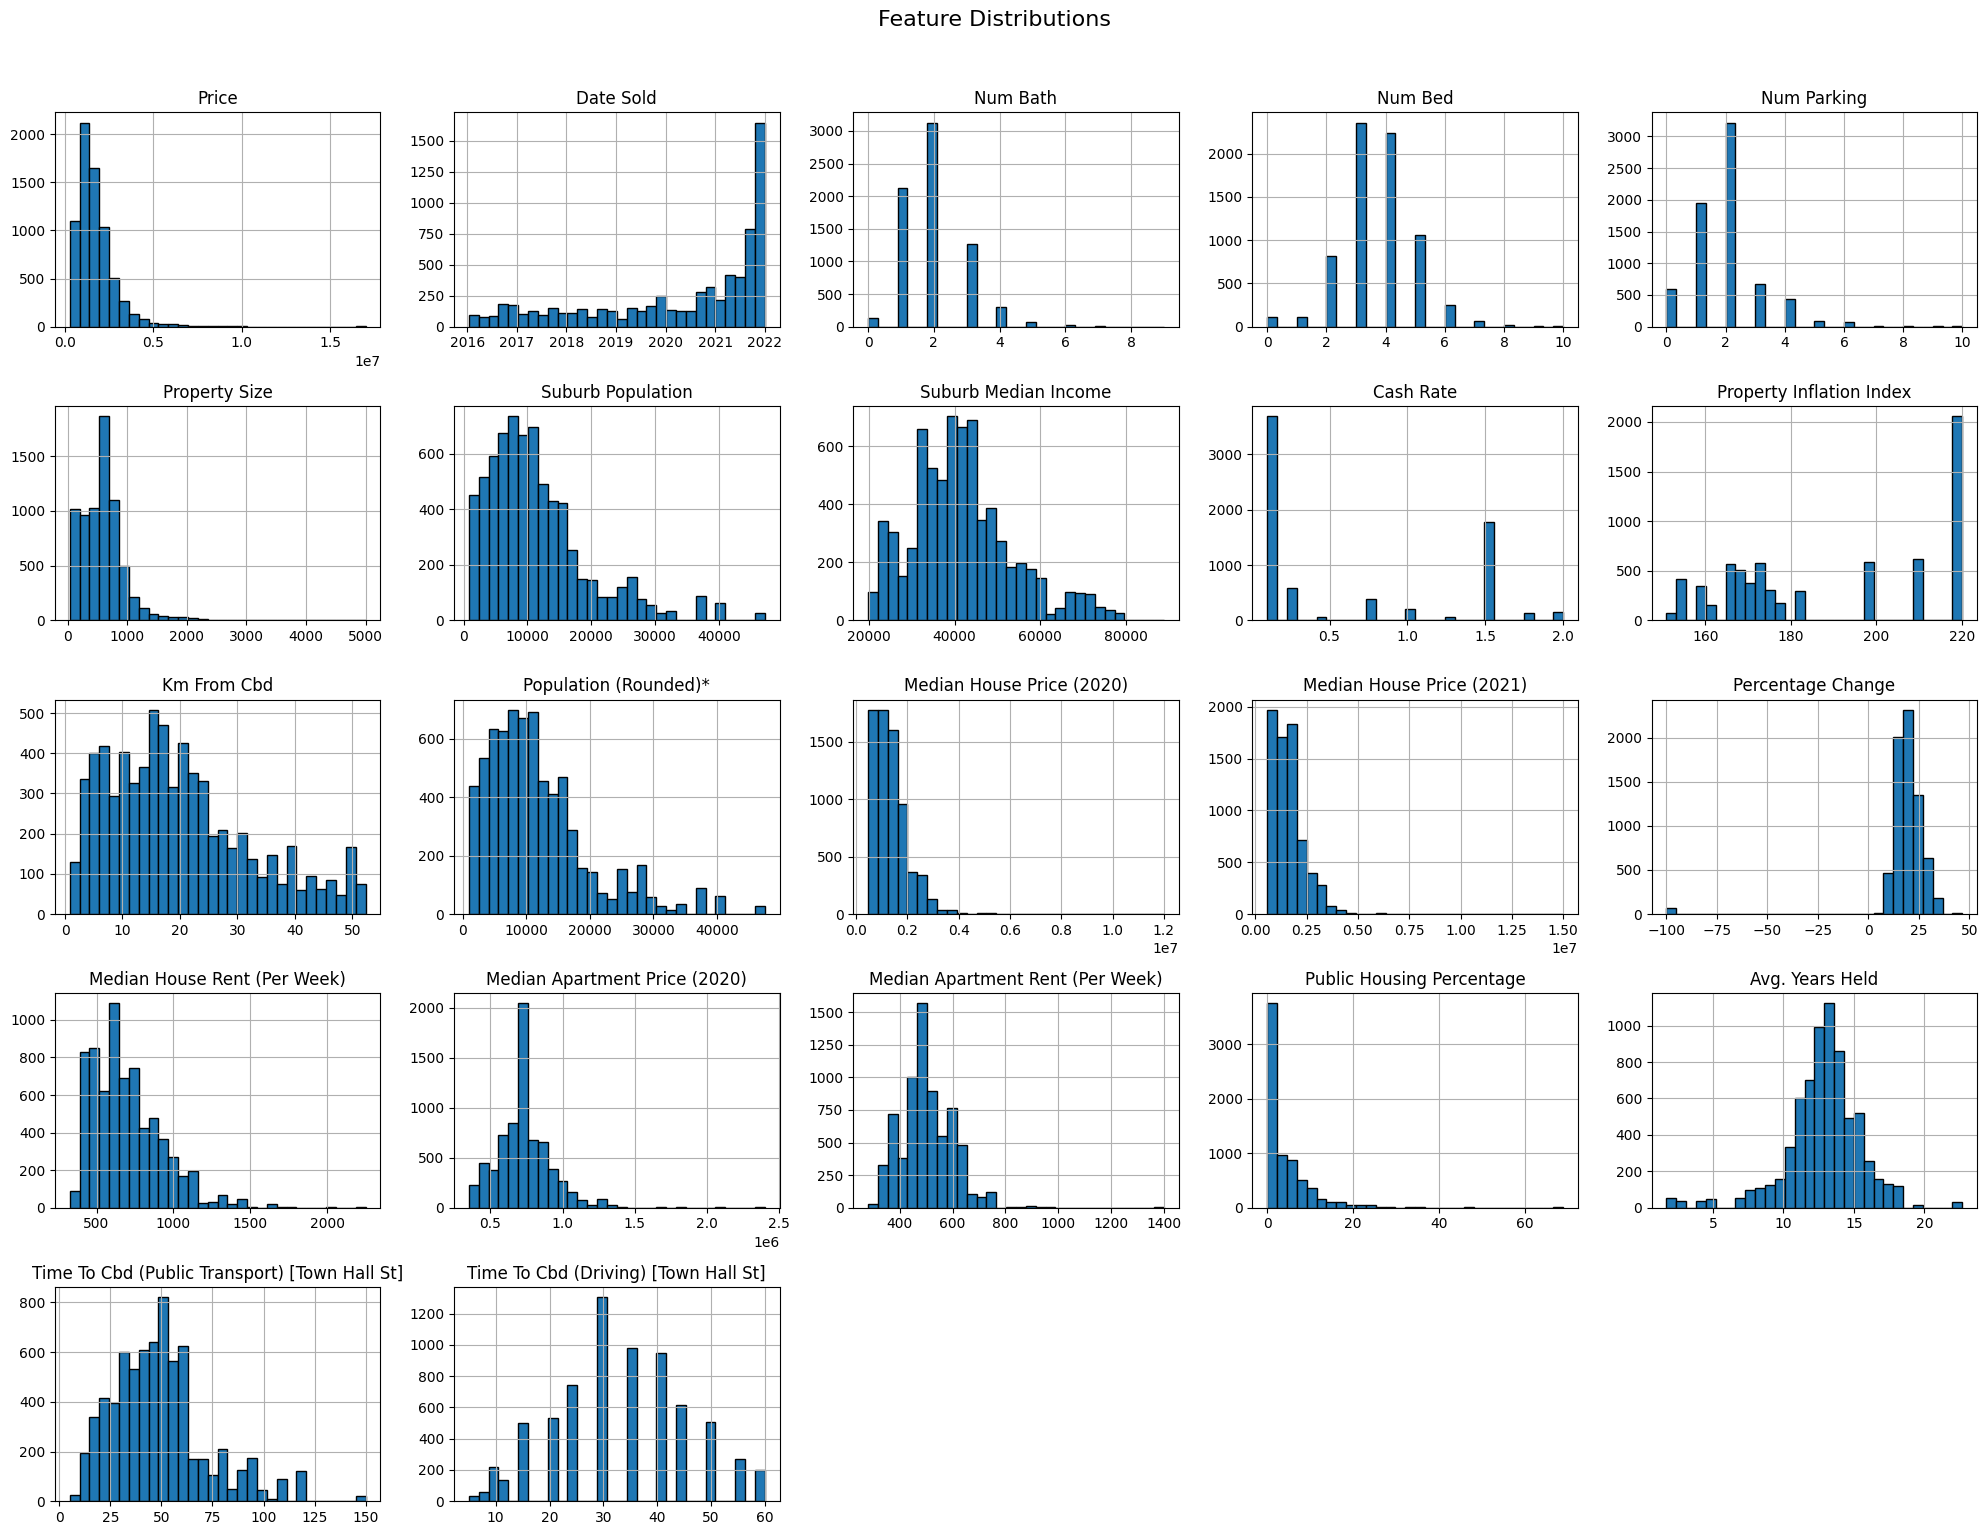

In [30]:
# FEATURE DISTRIBUTIONS
merged.hist(figsize=(20, 15), bins=30, edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

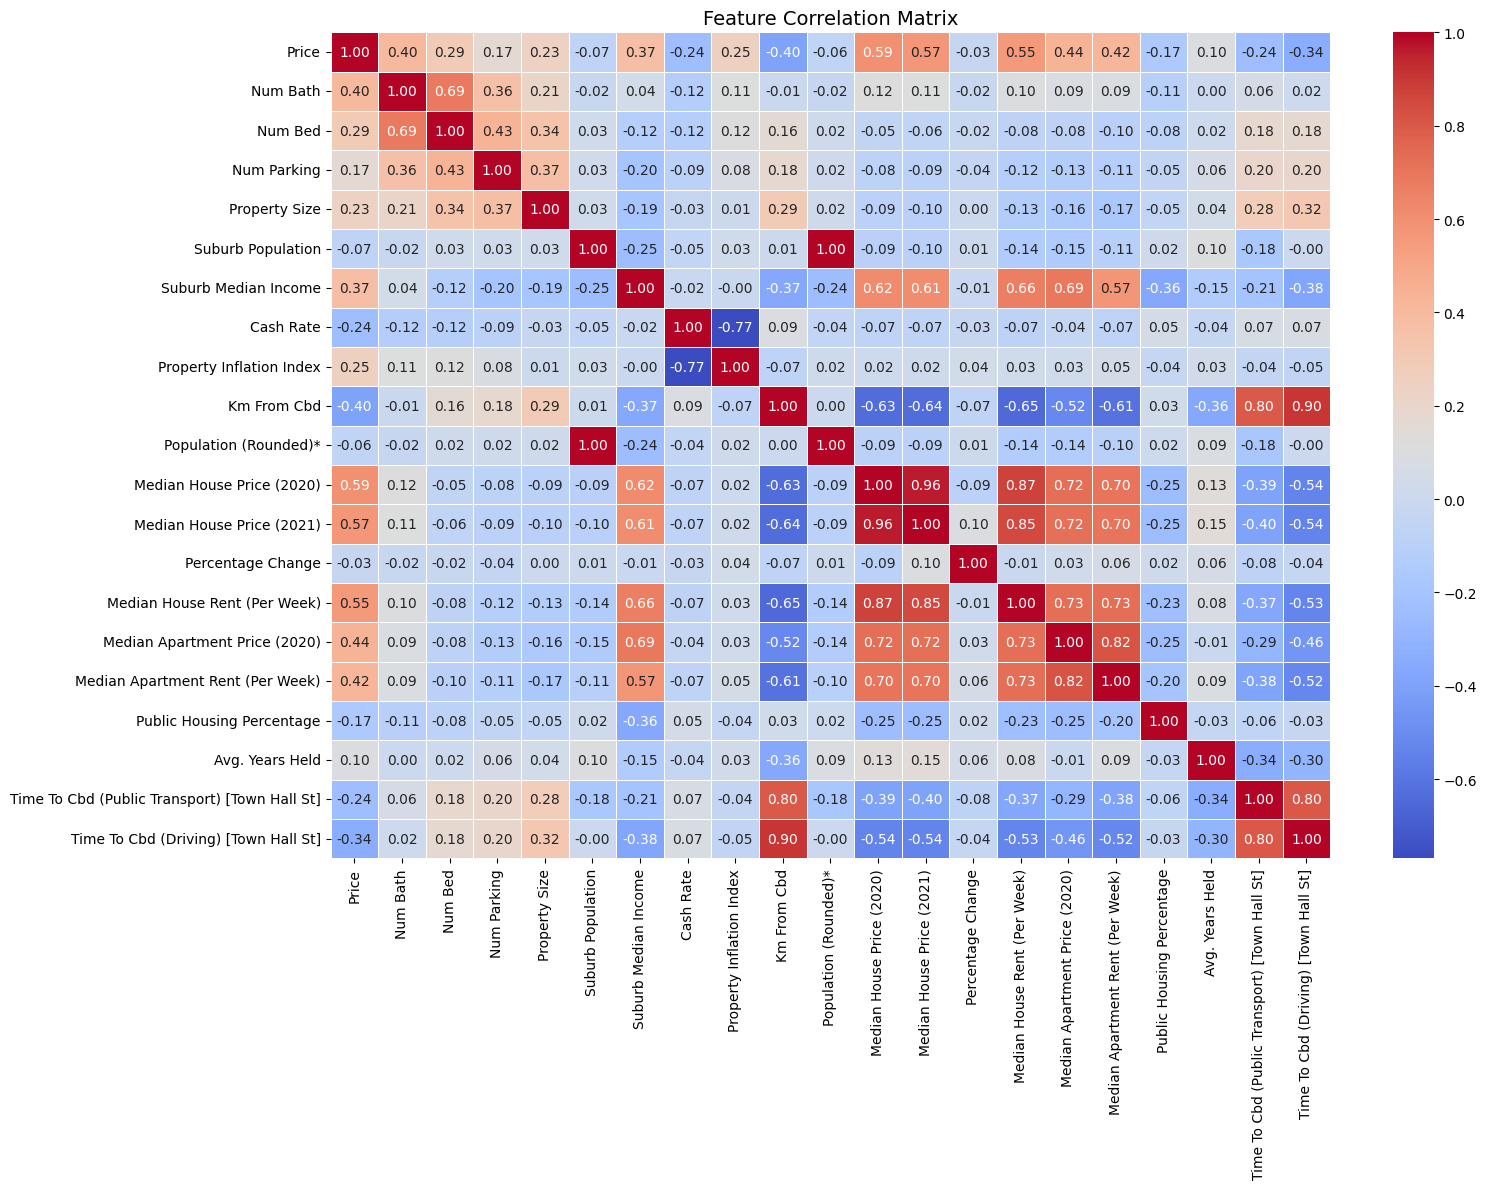

In [31]:
# CORRELATION HEATMAP
plt.figure(figsize=(16, 12))
sns.heatmap(
    merged.corr(numeric_only=True),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Feature Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

### Deep Cleaning

In [32]:
# FEATURE CORRELATION WITH PRICE
corr_matrix = merged.corr(numeric_only=True)
price_corr = corr_matrix["Price"].sort_values(ascending=False)
print(price_corr)

Price                                            1.000000
Median House Price (2020)                        0.594744
Median House Price (2021)                        0.568255
Median House Rent (Per Week)                     0.551381
Median Apartment Price (2020)                    0.435412
Median Apartment Rent (Per Week)                 0.421714
Num Bath                                         0.403851
Suburb Median Income                             0.370997
Num Bed                                          0.292065
Property Inflation Index                         0.252542
Property Size                                    0.234159
Num Parking                                      0.167249
Avg. Years Held                                  0.097980
Percentage Change                               -0.030060
Population (Rounded)*                           -0.063519
Suburb Population                               -0.066852
Public Housing Percentage                       -0.167552
Cash Rate     

In [33]:
# DROP LOW CORRELATION FEATURES
drop_cols = [
    "Avg. Years Held",
    "Percentage Change",
    "Public Housing Percentage",
    "Cash Rate"
]

merged.drop(columns=drop_cols, inplace=True, errors="ignore")
print("Remaining columns:", merged.columns.tolist())

Remaining columns: ['Price', 'Date Sold', 'Suburb', 'Num Bath', 'Num Bed', 'Num Parking', 'Property Size', 'Type', 'Suburb Population', 'Suburb Median Income', 'Property Inflation Index', 'Km From Cbd', 'Population (Rounded)*', 'Median House Price (2020)', 'Median House Price (2021)', 'Median House Rent (Per Week)', 'Median Apartment Price (2020)', 'Median Apartment Rent (Per Week)', 'Time To Cbd (Public Transport) [Town Hall St]', 'Time To Cbd (Driving) [Town Hall St]']


In [34]:
# MULTICOLLINEARITY CHECK
corr_matrix = merged.corr(numeric_only=True)
high_corr = corr_matrix.abs() >= 0.8
np.fill_diagonal(high_corr.values, False)
high_corr_pairs = (
    high_corr
    .where(high_corr)
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'High Correlation']
print(high_corr_pairs)

                               Feature 1  \
0                      Suburb Population   
1                            Km From Cbd   
2                  Population (Rounded)*   
3              Median House Price (2020)   
4              Median House Price (2020)   
5              Median House Price (2021)   
6              Median House Price (2021)   
7           Median House Rent (Per Week)   
8           Median House Rent (Per Week)   
9          Median Apartment Price (2020)   
10      Median Apartment Rent (Per Week)   
11  Time To Cbd (Driving) [Town Hall St]   

                               Feature 2 High Correlation  
0                  Population (Rounded)*             True  
1   Time To Cbd (Driving) [Town Hall St]             True  
2                      Suburb Population             True  
3              Median House Price (2021)             True  
4           Median House Rent (Per Week)             True  
5              Median House Price (2020)             True  
6      

In [35]:
# DROP MULTICOLLINEAR FEATURES
# For each highly correlated pair, drop the feature with LOWER correlation to price
to_drop = []
for _, row in high_corr_pairs.iterrows():
    f1, f2 = row["Feature 1"], row["Feature 2"]
    if f1 in price_corr.index and f2 in price_corr.index:
        # Keep the feature more correlated with price, drop the other
        drop_feature = f1 if abs(price_corr[f1]) <= abs(price_corr[f2]) else f2
        to_drop.append(drop_feature)

to_drop = list(set(to_drop))
print("Features being dropped due to multicollinearity:")
print(to_drop)

merged.drop(columns=to_drop, inplace=True, errors="ignore")
print("\nRemaining columns:", merged.columns.tolist())
print("Dataset shape:", merged.shape)

Features being dropped due to multicollinearity:
['Median House Price (2021)', 'Population (Rounded)*', 'Median House Rent (Per Week)', 'Time To Cbd (Driving) [Town Hall St]', 'Median Apartment Rent (Per Week)']

Remaining columns: ['Price', 'Date Sold', 'Suburb', 'Num Bath', 'Num Bed', 'Num Parking', 'Property Size', 'Type', 'Suburb Population', 'Suburb Median Income', 'Property Inflation Index', 'Km From Cbd', 'Median House Price (2020)', 'Median Apartment Price (2020)', 'Time To Cbd (Public Transport) [Town Hall St]']
Dataset shape: (7050, 15)


### Exploratory Data Analysis

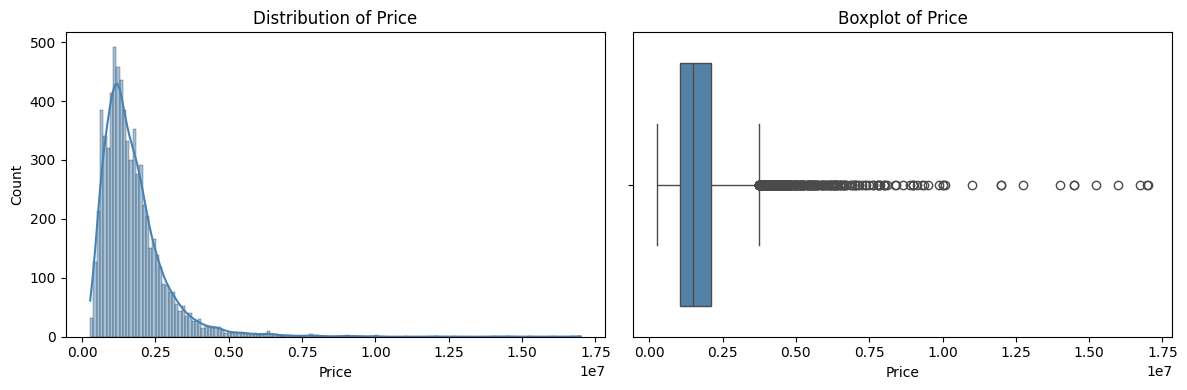

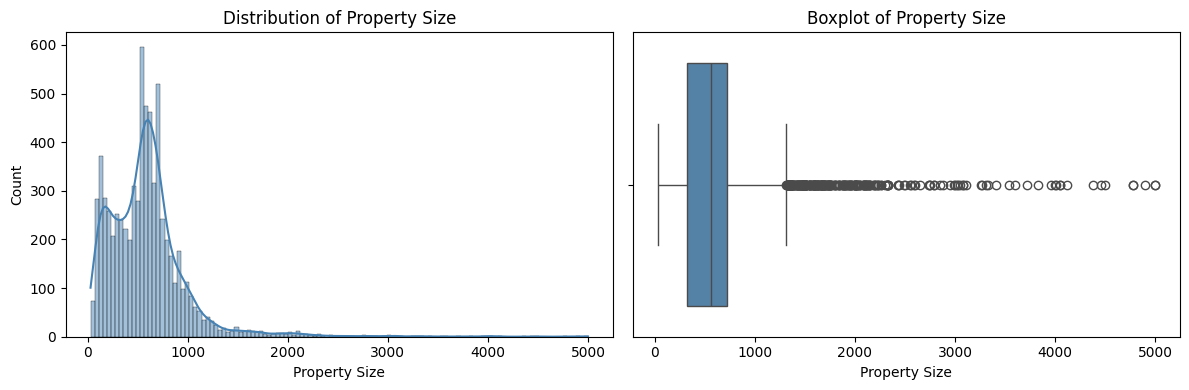

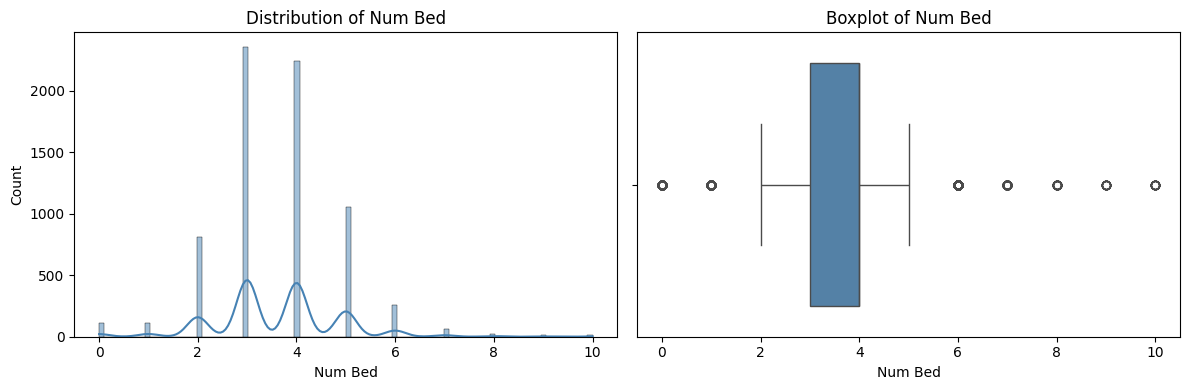

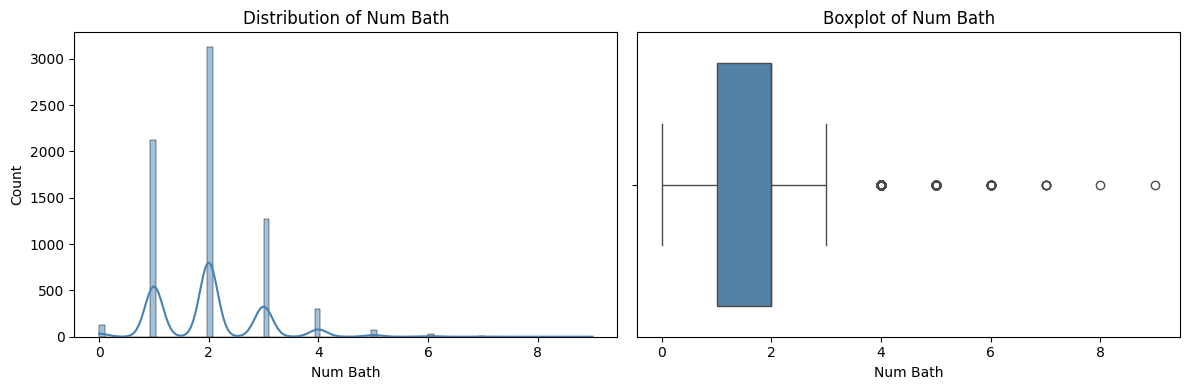

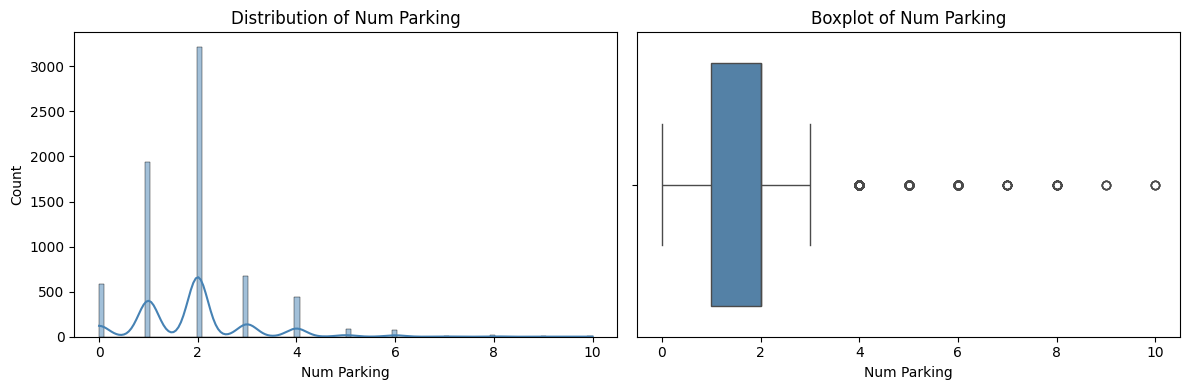

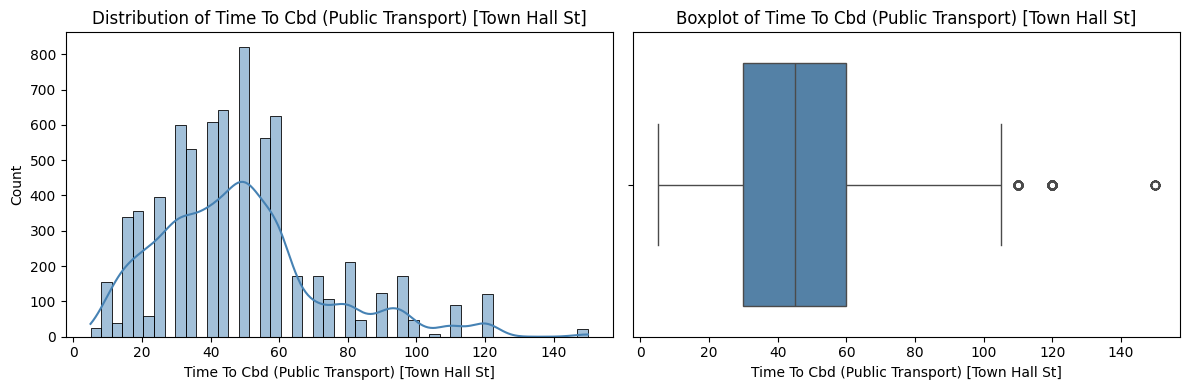

In [36]:
# DISTRIBUTION AND OUTLIER CHECK FOR KEY FEATURES
key_features = [
    "Price", "Property Size", "Num Bed", "Num Bath",
    "Num Parking", "Median House Rent (Per Week)",
    "Time To Cbd (Public Transport) [Town Hall St]", 
    "Time To Cbd (Driving) [Town Hall St]"
]

for col in key_features:
    if col in merged.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(merged[col], kde=True, ax=axes[0], color='steelblue')
        axes[0].set_title(f'Distribution of {col}')
        sns.boxplot(x=merged[col], ax=axes[1], color='steelblue')
        axes[1].set_title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

In [37]:
# COPY MERGED DATASET FOR MODELLING
# Preserving cleaned merged dataset before feature engineering
merged_lr = merged.copy()
print("Dataset copied for modelling. Shape:", merged_lr.shape)

Dataset copied for modelling. Shape: (7050, 15)


### Feature Engineering

In [38]:
# LOG TRANSFORMATION FOR SKEWED FEATURES
log_transform_cols = [
    "Price",
    "Property Size",
    "Population (Rounded)*",
    "Median House Price (2020)",
    "Median House Price (2021)",
    "Median House Rent (Per Week)",
    "Median Apartment Price (2020)",
    "Median Apartment Rent (Per Week)"
]

for col in log_transform_cols:
    if col in merged_lr.columns:
        merged_lr[col] = np.log1p(merged_lr[col])

print("Log transformation applied to:", log_transform_cols)

Log transformation applied to: ['Price', 'Property Size', 'Population (Rounded)*', 'Median House Price (2020)', 'Median House Price (2021)', 'Median House Rent (Per Week)', 'Median Apartment Price (2020)', 'Median Apartment Rent (Per Week)']


In [39]:
# CAP OUTLIERS IN PROPERTY FEATURES
merged_lr["Num Bath"] = merged_lr["Num Bath"].clip(upper=6)
merged_lr["Num Bed"] = merged_lr["Num Bed"].clip(upper=6)
merged_lr["Num Parking"] = merged_lr["Num Parking"].clip(upper=6)

print("Outlier capping applied to Num Bath, Num Bed, Num Parking")

Outlier capping applied to Num Bath, Num Bed, Num Parking


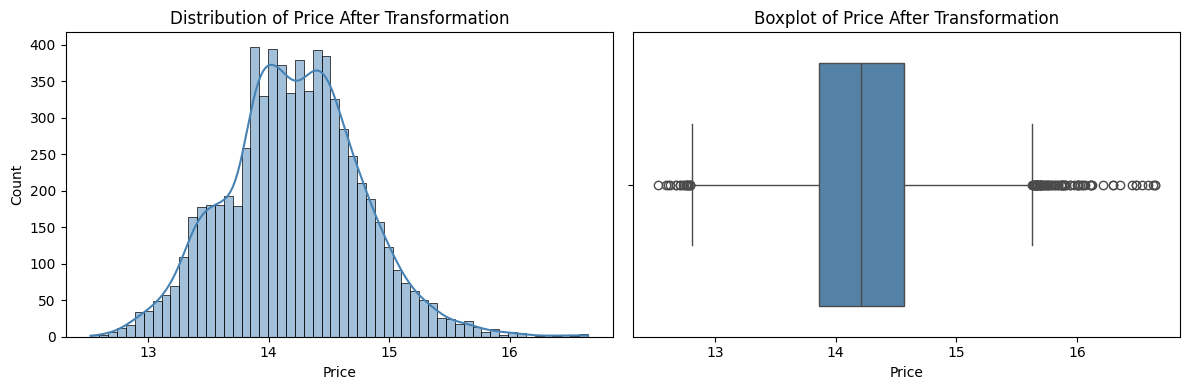

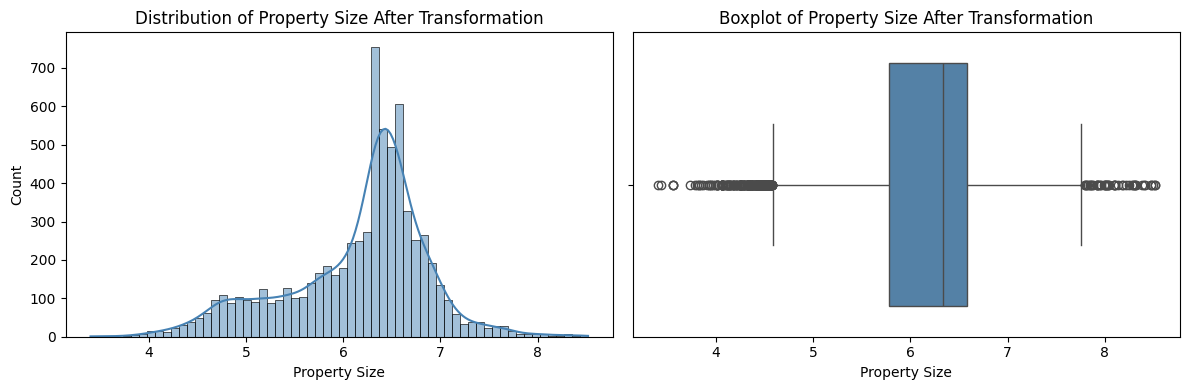

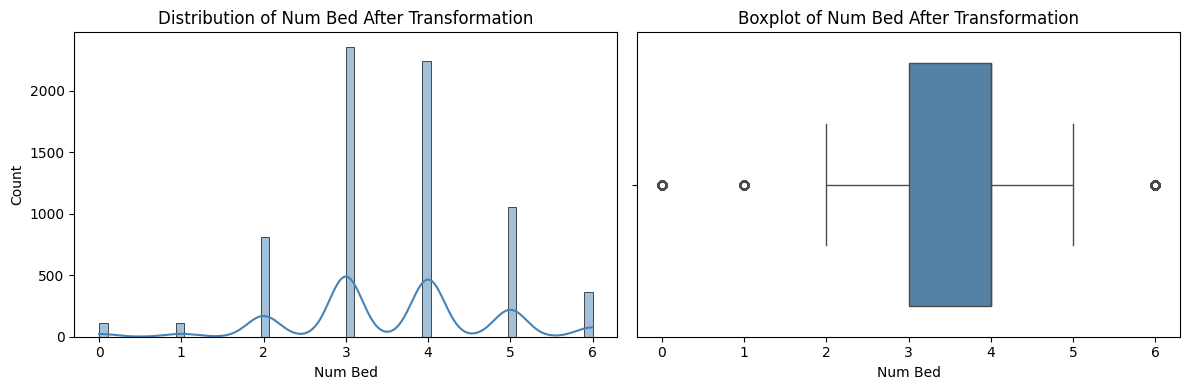

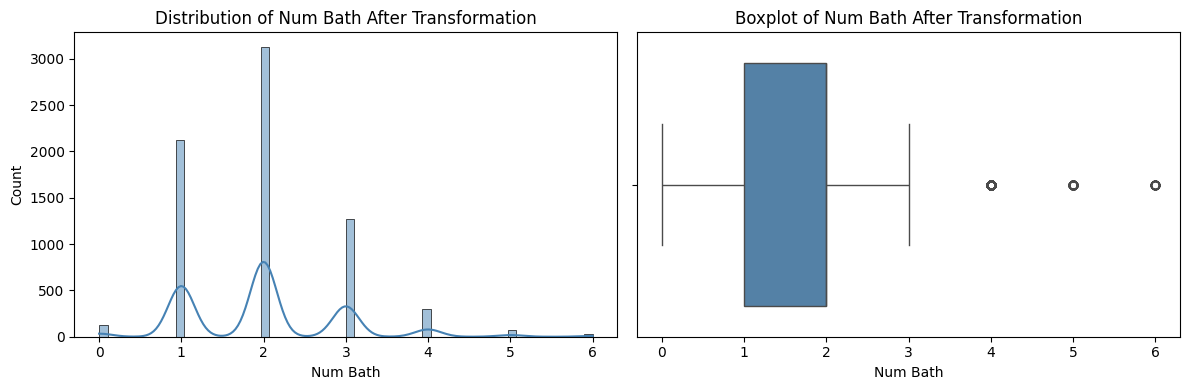

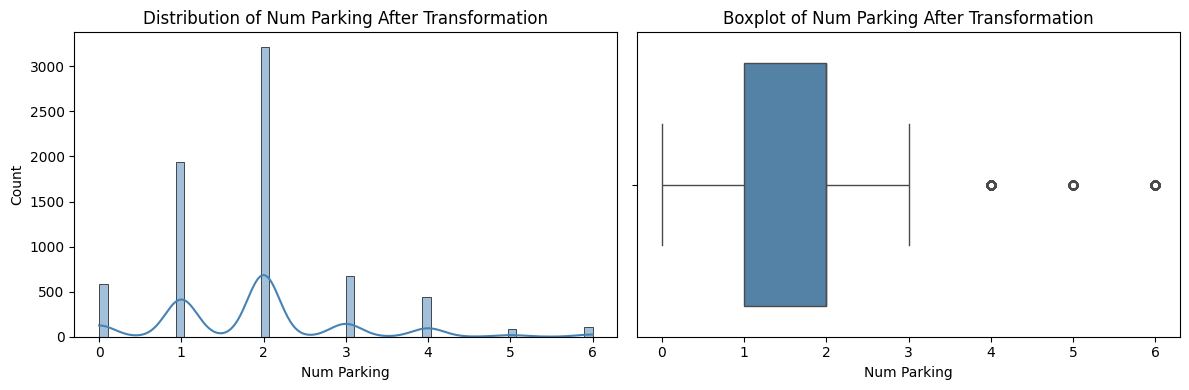

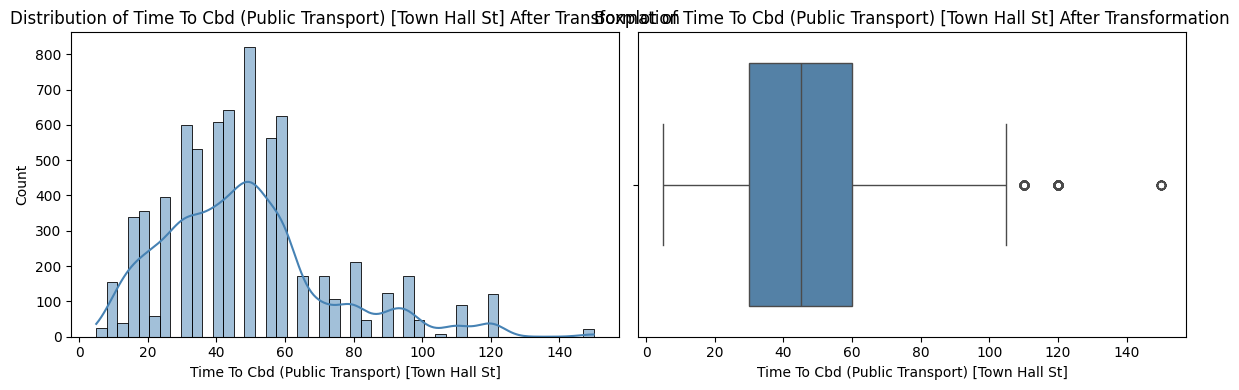

In [40]:
# DISTRIBUTION CHECK AFTER TRANSFORMATIONS
key_features = [
    "Price", "Property Size", "Num Bed", "Num Bath",
    "Num Parking", "Median House Rent (Per Week)",
    "Time To Cbd (Public Transport) [Town Hall St]",
    "Time To Cbd (Driving) [Town Hall St]"
]

for col in key_features:
    if col in merged_lr.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(merged_lr[col], kde=True, ax=axes[0], color='steelblue')
        axes[0].set_title(f'Distribution of {col} After Transformation')
        sns.boxplot(x=merged_lr[col], ax=axes[1], color='steelblue')
        axes[1].set_title(f'Boxplot of {col} After Transformation')
        plt.tight_layout()
        plt.show()

In [41]:
# ONE HOT ENCODE PROPERTY TYPE
merged_lr = pd.get_dummies(merged_lr, columns=["Type"], drop_first=True)

# Rename dummy columns for readability
merged_lr.rename(columns={
    "Type_House": "Is House",
    "Type_Land": "Is Land",
    "Type_Off The Plan Apartments": "Is Off Plan Apartment",
    "Type_Off The Plan House": "Is Off Plan House",
    "Type_Other": "Is Other"
}, inplace=True)

print("Encoded columns:", [col for col in merged_lr.columns if col.startswith("Is")])
print("Dataset shape:", merged_lr.shape)

Encoded columns: ['Is House', 'Is Land', 'Is Other']
Dataset shape: (7050, 19)


### Train-Test Split & Scaling

In [42]:
# TRAIN TEST SPLIT
X = merged_lr.drop(columns=["Price", "Suburb", "Date Sold"])
y = merged_lr["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete")
print("Train mean (should be ~0):", X_train_scaled.mean().round(4))
print("Train std (should be ~1):", X_train_scaled.std().round(4))

Scaling complete
Train mean (should be ~0): 0.0
Train std (should be ~1): 1.0


### Baseline Linear Regression

In [44]:
# BASELINE LINEAR REGRESSION
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_y_pred = lr_model.predict(X_test_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_y_pred))
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_mae = mean_absolute_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print("Baseline Linear Regression Results:")
print(f"  RMSE : {lr_rmse:.4f}")
print(f"  MSE  : {lr_mse:.4f}")
print(f"  MAE  : {lr_mae:.4f}")
print(f"  R²   : {lr_r2:.4f}")

Baseline Linear Regression Results:
  RMSE : 0.2377
  MSE  : 0.0565
  MAE  : 0.1739
  R²   : 0.8123


### Residual Diagnostics

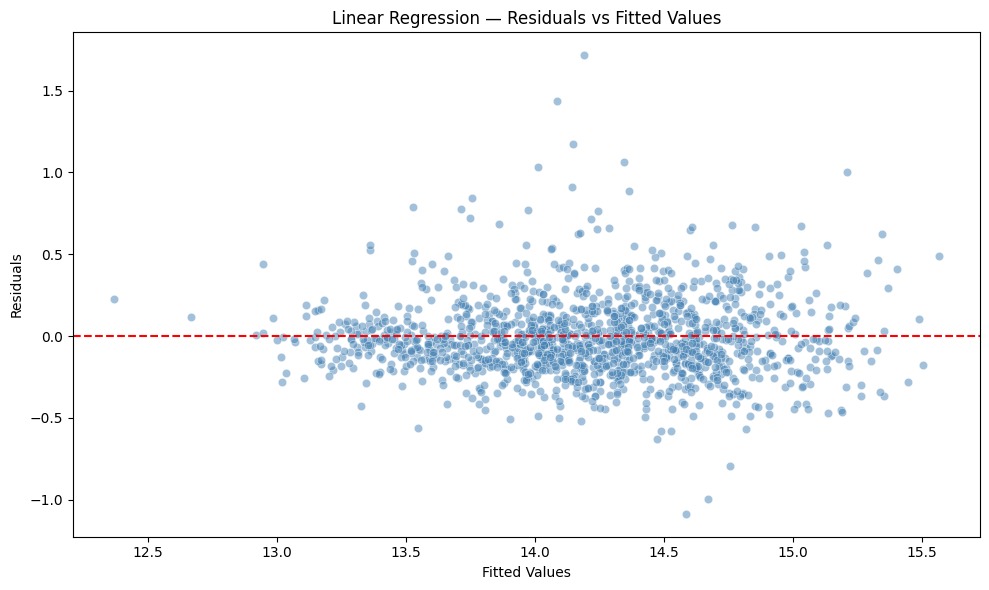

In [45]:
# LINEAR REGRESSION RESIDUAL ANALYSIS
lr_residuals = y_test - lr_y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=lr_y_pred, y=lr_residuals, alpha=0.5, color='steelblue')
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Linear Regression — Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

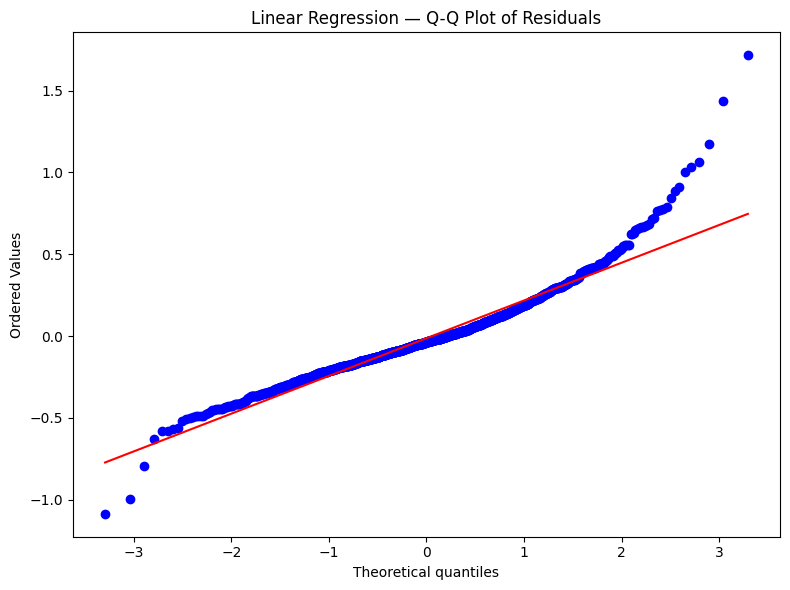

In [46]:
# Q-Q PLOT — CHECKING NORMALITY OF RESIDUALS
plt.figure(figsize=(8, 6))
stats.probplot(lr_residuals, dist="norm", plot=plt)
plt.title("Linear Regression — Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

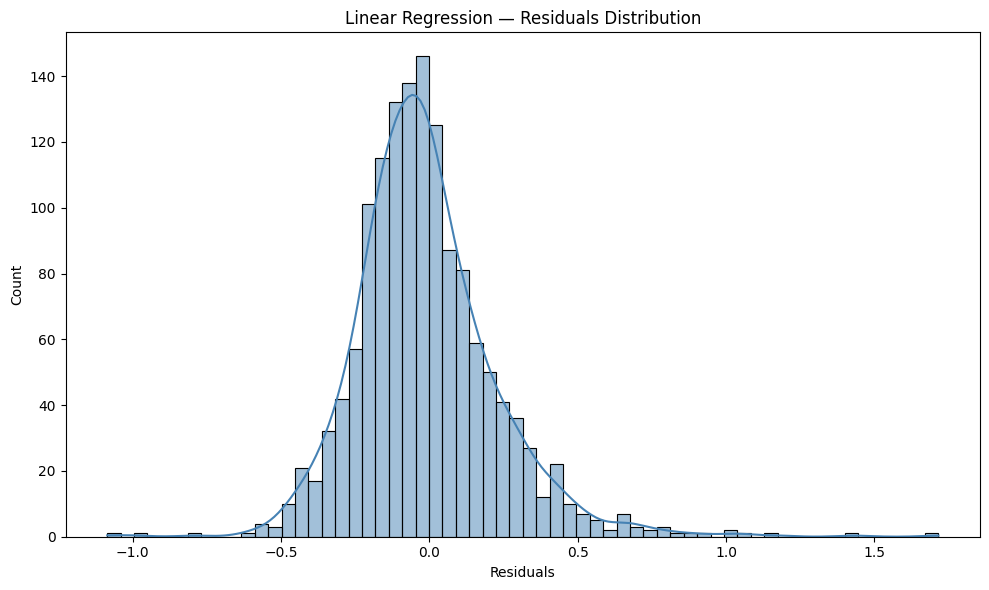

In [47]:
# RESIDUALS DISTRIBUTION
plt.figure(figsize=(10, 6))
sns.histplot(lr_residuals, kde=True, color='steelblue', edgecolor='black')
plt.xlabel("Residuals")
plt.title("Linear Regression — Residuals Distribution")
plt.tight_layout()
plt.show()

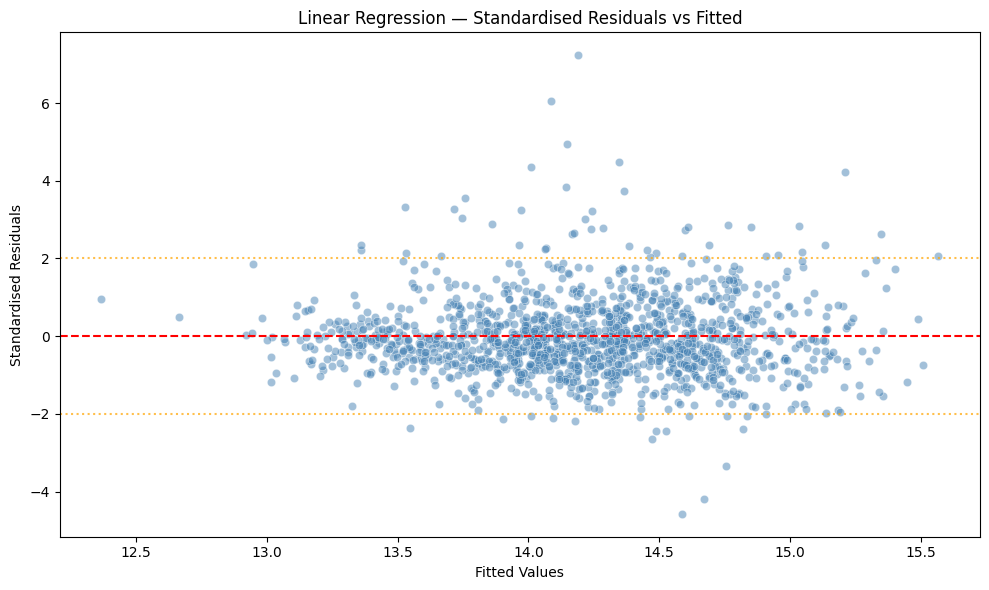

In [48]:
# STANDARDISED RESIDUALS VS FITTED
std_residuals = lr_residuals / np.std(lr_residuals)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=lr_y_pred, y=std_residuals, alpha=0.5, color='steelblue')
plt.axhline(0, color="red", linestyle="--")
plt.axhline(2, color="orange", linestyle=":", alpha=0.7)
plt.axhline(-2, color="orange", linestyle=":", alpha=0.7)
plt.xlabel("Fitted Values")
plt.ylabel("Standardised Residuals")
plt.title("Linear Regression — Standardised Residuals vs Fitted")
plt.tight_layout()
plt.show()

### Interaction Model

In [49]:
# FEATURE INTERACTIONS
X_train_interaction = X_train.copy()
X_test_interaction = X_test.copy()

# Num Bed × Property Size — larger homes with more bedrooms
X_train_interaction["Bed X Size"] = X_train_interaction["Num Bed"] * X_train_interaction["Property Size"]
X_test_interaction["Bed X Size"] = X_test_interaction["Num Bed"] * X_test_interaction["Property Size"]

# Num Bath × Property Size — bathroom count relative to property size
X_train_interaction["Bath X Size"] = X_train_interaction["Num Bath"] * X_train_interaction["Property Size"]
X_test_interaction["Bath X Size"] = X_test_interaction["Num Bath"] * X_test_interaction["Property Size"]

# Suburb Median Income × Km From Cbd — wealthy suburbs close to city
X_train_interaction["Income X Distance"] = X_train_interaction["Suburb Median Income"] * X_train_interaction["Km From Cbd"]
X_test_interaction["Income X Distance"] = X_test_interaction["Suburb Median Income"] * X_test_interaction["Km From Cbd"]

# Num Parking × Suburb Median Income — parking value in wealthier suburbs
X_train_interaction["Parking X Income"] = X_train_interaction["Num Parking"] * X_train_interaction["Suburb Median Income"]
X_test_interaction["Parking X Income"] = X_test_interaction["Num Parking"] * X_test_interaction["Suburb Median Income"]

print("Interaction features added:", ["Bed X Size", "Bath X Size", "Income X Distance", "Parking X Income"])

Interaction features added: ['Bed X Size', 'Bath X Size', 'Income X Distance', 'Parking X Income']


In [50]:
# RETRAIN LINEAR REGRESSION WITH INTERACTION TERMS
X_train_interaction_scaled = scaler.fit_transform(X_train_interaction)
X_test_interaction_scaled = scaler.transform(X_test_interaction)

lr_interaction_model = LinearRegression()
lr_interaction_model.fit(X_train_interaction_scaled, y_train)
lr_y_pred_interaction = lr_interaction_model.predict(X_test_interaction_scaled)

lr_rmse_interaction = np.sqrt(mean_squared_error(y_test, lr_y_pred_interaction))
lr_mse_interaction = mean_squared_error(y_test, lr_y_pred_interaction)
lr_mae_interaction = mean_absolute_error(y_test, lr_y_pred_interaction)
lr_r2_interaction = r2_score(y_test, lr_y_pred_interaction)

print("Linear Regression with Interaction Terms:")
print(f"  RMSE : {lr_rmse_interaction:.4f}")
print(f"  MSE  : {lr_mse_interaction:.4f}")
print(f"  MAE  : {lr_mae_interaction:.4f}")
print(f"  R²   : {lr_r2_interaction:.4f}")

Linear Regression with Interaction Terms:
  RMSE : 0.2366
  MSE  : 0.0560
  MAE  : 0.1738
  R²   : 0.8141


### Regularisation Models

In [51]:
# REGULARISATION — RIDGE, LASSO, ELASTICNET
alphas = np.logspace(-4, 4, 100)

# Ridge
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_interaction_scaled, y_train)
ridge_y_pred = ridge_cv.predict(X_test_interaction_scaled)

# Lasso
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_interaction_scaled, y_train)
lasso_y_pred = lasso_cv.predict(X_test_interaction_scaled)

# ElasticNet
elasticnet_cv = ElasticNetCV(
    alphas=alphas,
    l1_ratio=np.linspace(0.1, 0.9, 9),
    cv=5,
    max_iter=10000
)
elasticnet_cv.fit(X_train_interaction_scaled, y_train)
elasticnet_y_pred = elasticnet_cv.predict(X_test_interaction_scaled)

print("Regularisation models trained")
print(f"  Best Ridge alpha    : {ridge_cv.alpha_:.4f}")
print(f"  Best Lasso alpha    : {lasso_cv.alpha_:.4f}")
print(f"  Best ElasticNet alpha: {elasticnet_cv.alpha_:.4f}")

Regularisation models trained
  Best Ridge alpha    : 2.3101
  Best Lasso alpha    : 0.0001
  Best ElasticNet alpha: 0.0002


In [52]:
# REGULARISATION RESULTS
def evaluate_model(name, y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name}:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MSE  : {mse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")
    return {"Model": name, "RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}

results = []
results.append(evaluate_model("Ridge Regression", y_test, ridge_y_pred))
results.append(evaluate_model("Lasso Regression", y_test, lasso_y_pred))
results.append(evaluate_model("ElasticNet Regression", y_test, elasticnet_y_pred))


Ridge Regression:
  RMSE : 0.2364
  MSE  : 0.0559
  MAE  : 0.1738
  R²   : 0.8144

Lasso Regression:
  RMSE : 0.2364
  MSE  : 0.0559
  MAE  : 0.1738
  R²   : 0.8143

ElasticNet Regression:
  RMSE : 0.2364
  MSE  : 0.0559
  MAE  : 0.1737
  R²   : 0.8144


### Decision Tree Model

In [53]:
# BASELINE DECISION TREE
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_interaction, y_train)
dt_y_pred = dt_model.predict(X_test_interaction)

results.append(evaluate_model("Baseline Decision Tree", y_test, dt_y_pred))


Baseline Decision Tree:
  RMSE : 0.3046
  MSE  : 0.0928
  MAE  : 0.2115
  R²   : 0.6918


In [54]:
# TUNED DECISION TREE — GRIDSEARCH
dt_params = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=dt_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
dt_grid.fit(X_train_interaction, y_train)
best_dt = dt_grid.best_estimator_

print("Best Decision Tree parameters:")
print(dt_grid.best_params_)

dt_y_pred_best = best_dt.predict(X_test_interaction)
results.append(evaluate_model("Tuned Decision Tree", y_test, dt_y_pred_best))

Best Decision Tree parameters:
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Tuned Decision Tree:
  RMSE : 0.2504
  MSE  : 0.0627
  MAE  : 0.1797
  R²   : 0.7918


In [55]:
# RANDOM FOREST — GRIDSEARCH
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
rf_grid.fit(X_train_interaction, y_train)
best_rf = rf_grid.best_estimator_

print("Best Random Forest parameters:")
print(rf_grid.best_params_)

Best Random Forest parameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [56]:
# RANDOM FOREST RESULTS
rf_y_pred_best = best_rf.predict(X_test_interaction)
results.append(evaluate_model("Random Forest", y_test, rf_y_pred_best))


Random Forest:
  RMSE : 0.2092
  MSE  : 0.0437
  MAE  : 0.1469
  R²   : 0.8547


In [57]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(best_rf, "models/best_rf_model.pkl")
print("Model saved successfully to models/best_rf_model.pkl")

Model saved successfully to models/best_rf_model.pkl


### Model Comparison Plots

In [58]:
# MODEL COMPARISON TABLE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("R2", ascending=False).reset_index(drop=True)
print(results_df.to_string(index=False))

                 Model     RMSE      MSE      MAE       R2
         Random Forest 0.209153 0.043745 0.146902 0.854692
 ElasticNet Regression 0.236384 0.055877 0.173737 0.814392
      Ridge Regression 0.236403 0.055887 0.173776 0.814361
      Lasso Regression 0.236418 0.055893 0.173766 0.814339
   Tuned Decision Tree 0.250369 0.062685 0.179673 0.791780
Baseline Decision Tree 0.304620 0.092793 0.211520 0.691769


### Model Comparison Table
| Model                            | RMSE   | MSE     | MAE     | R²      |
| -------------------------------- | ------ | ------- | ------- | ------- |
| Linear Regression                | 0.2361 | 0.05573 | 0.17434 | 0.81488 |
| Linear Regression + Interactions | 0.2358 | 0.05560 | 0.17415 | 0.81533 |
| Ridge Regression                 | 0.2357 | 0.05555 | 0.17397 | 0.81546 |
| Lasso Regression                 | 0.2358 | 0.05559 | 0.17396 | 0.81533 |
| ElasticNet Regression            | 0.2358 | 0.05561 | 0.17398 | 0.81529 |
| Decision Tree                    | 0.2798 | 0.07826 | 0.20189 | 0.74003 |
| Tuned Decision Tree              | 0.2527 | 0.06384 | 0.18311 | 0.78795 |
| Random Forest                    | 0.2157 | 0.04651 | 0.15244 | 0.84550 |

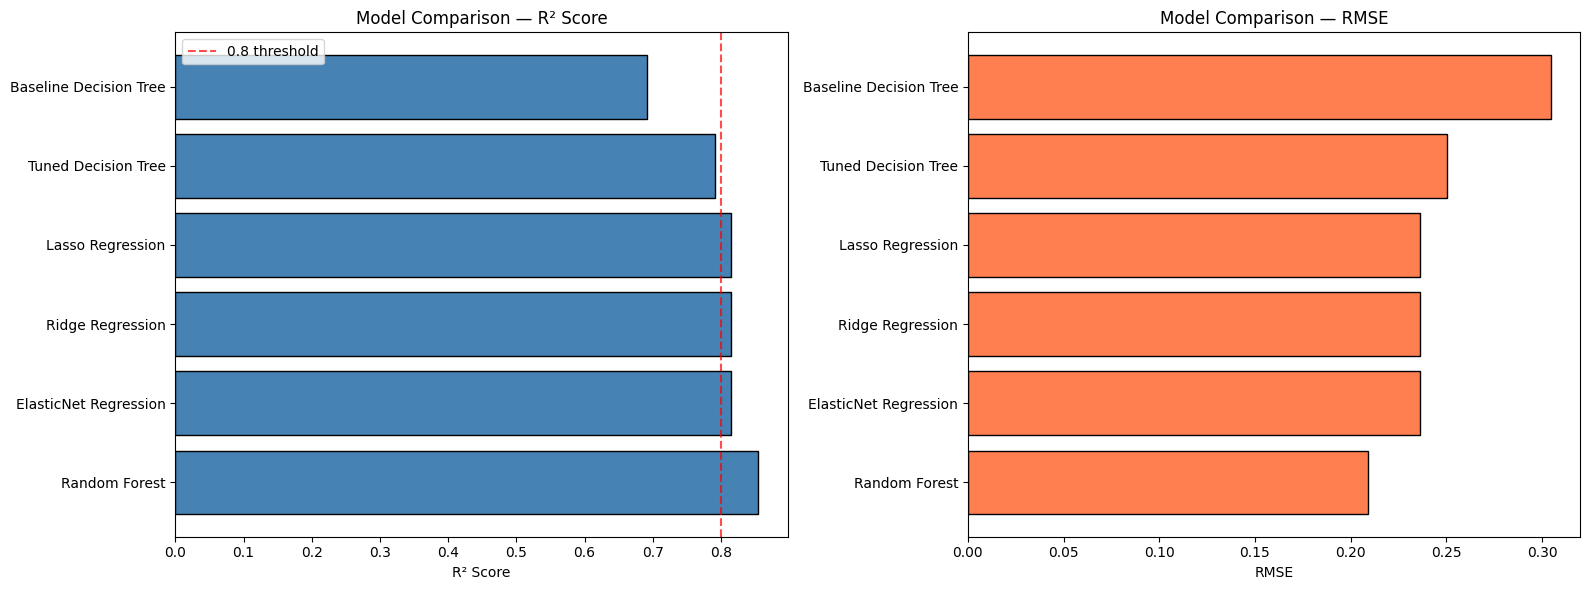

In [59]:
# MODEL PERFORMANCE COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² Score
axes[0].barh(results_df["Model"], results_df["R2"], color='steelblue', edgecolor='black')
axes[0].set_xlabel("R² Score")
axes[0].set_title("Model Comparison — R² Score")
axes[0].axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='0.8 threshold')
axes[0].legend()

# RMSE
axes[1].barh(results_df["Model"], results_df["RMSE"], color='coral', edgecolor='black')
axes[1].set_xlabel("RMSE")
axes[1].set_title("Model Comparison — RMSE")

plt.tight_layout()
plt.show()

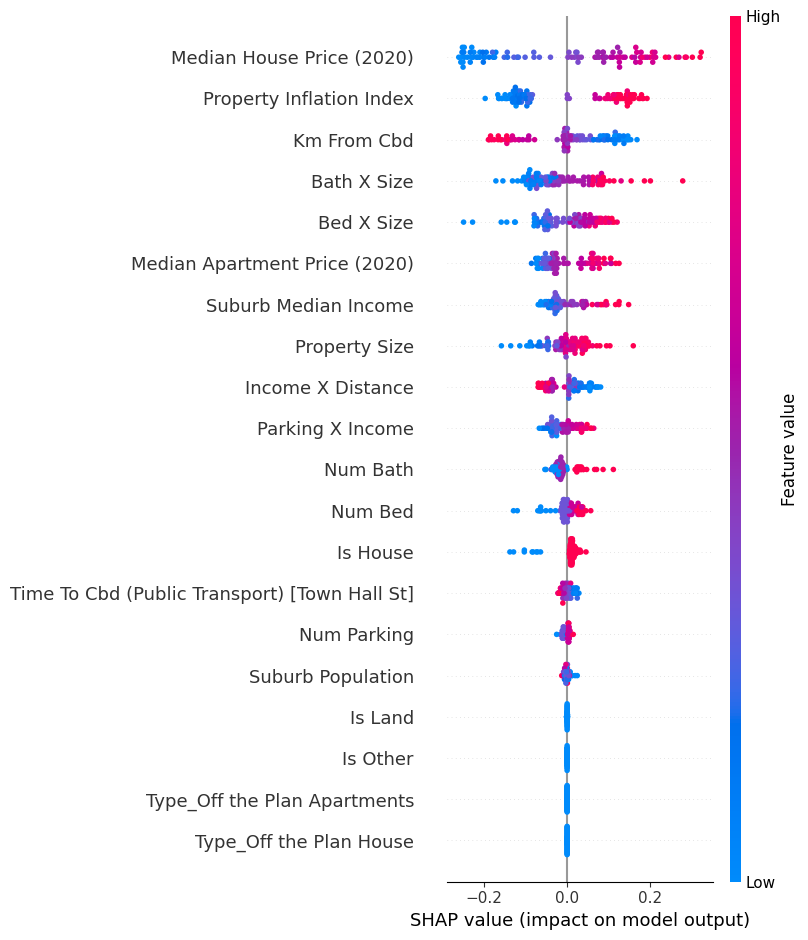

In [60]:
# SHAP FEATURE IMPORTANCE
X_shap_sample = X_test_interaction.sample(100, random_state=42)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_shap_sample)

shap.summary_plot(shap_values, X_shap_sample)

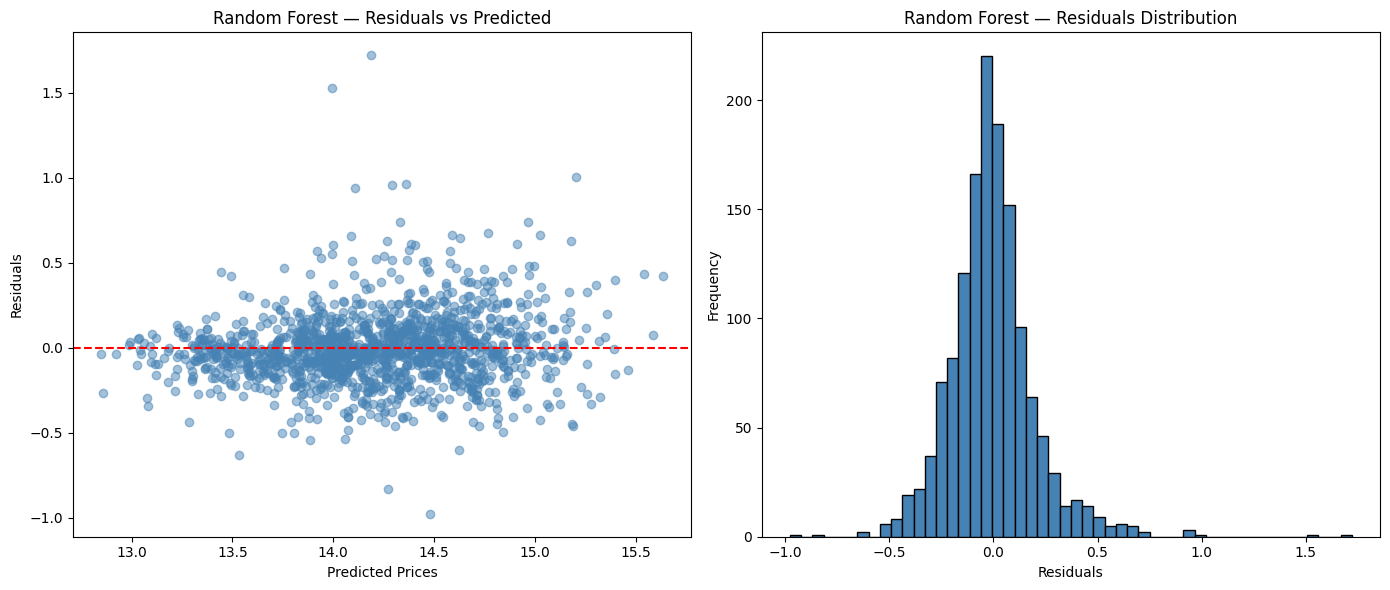

In [61]:
# RANDOM FOREST RESIDUAL ANALYSIS
residuals = y_test - rf_y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Predicted
axes[0].scatter(rf_y_pred_best, residuals, alpha=0.5, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Prices')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Random Forest — Residuals vs Predicted')

# Residuals Distribution
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Random Forest — Residuals Distribution')

plt.tight_layout()
plt.show()